# Importing Libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Loading the Data

In [3]:
SEED = 42 # For reprodicibility
IMG_SIZE = (224, 224)

# ----- Creating a train dataset object (tf.data.Dataset)----- #
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory='../datasets/train',
    label_mode='categorical',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=32,
    labels='inferred',
)
# ----- Creating a test dataset object (tf.data.Dataset)----- #
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  directory='../datasets/test', 
  label_mode='categorical',
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=32,
  labels='inferred',
)

# ----- Creating a validation dataset object (tf.data.Dataset)----- #
val_set = tf.keras.preprocessing.image_dataset_from_directory(
  directory='../datasets/validation',
  label_mode='categorical',
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=32,
  labels='inferred',
)

Found 1034 files belonging to 3 classes.
Found 128 files belonging to 3 classes.
Found 133 files belonging to 3 classes.


# Visualizing Samples from Dataset

In [23]:
# Category list
class_names = train_set.class_names

# Visualizing samples from the training set
class_images = {cat: [] for cat in class_names}

for image, labels in train_set.unbatch():
    label = np.argmax(labels.numpy())
    cat = class_names[label]
    # Take 5 images per class
    if len(class_images[cat]) < 5:
        class_images[cat].append(image.numpy())
    if all(len(images) >= 5 for images in class_images.values()):
        break

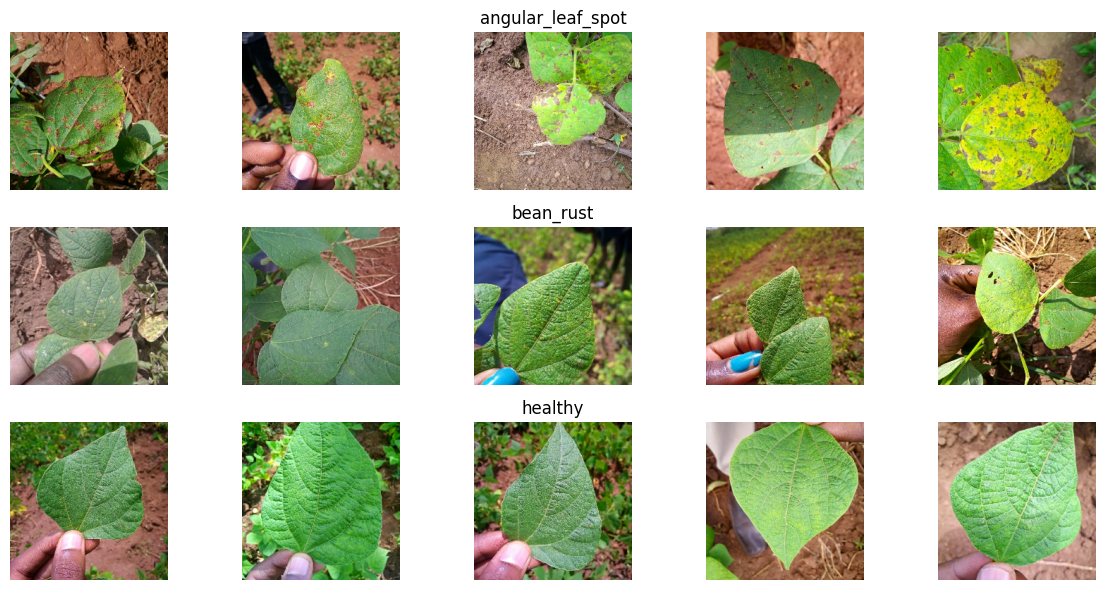

In [28]:
# Function for plotting the sample images
def plot_images(cnames: list, cimages: dict):
    fig, axes = plt.subplots(len(cnames), 5, figsize=(12, 6))

    for i, cat in enumerate(cnames):
        for j in range(5):
            if j < len(cimages[cat]):
                ax = axes[i, j]
                ax.imshow(cimages[cat][j] / 255.) # /255. to normalize RGB values of image
                # Turn off ticks for better display
                ax.axis('off')
                # Placing category name at middle image
                if j == 2:
                    ax.set_title(cat) 
    plt.tight_layout()
    plt.savefig('../images/dataset_prev.png')
    plt.show()

# Plot the images
plot_images(class_names, class_images)